# Object Detection using Selective Search

We will be using concepts of Selective Search and Non-Maxima Supression to turn almost any Image Classifier into an Object Detector
* **Selective Search**: 
  * Selective Search algorithm over-segments an image via:
    * Color similarity: Computing a 25-bin histogram for each channel of an image, concatenating them together, and obtaining a final descriptor that is 25×3=75-d. Color similarity of any two regions is measured by the histogram intersection distance.
    * Texture similarity: For texture, Selective Search extracts Gaussian derivatives at 8 orientations per channel (assuming a 3-channel image). These orientations are used to compute a 10-bin histogram per channel, generating a final texture descriptor that is 8x10x=240-d. To compute texture similarity between any two regions, histogram intersection is once again used.
    * Size similarity: The size similarity metric that Selective Search uses prefers that smaller regions be grouped earlier rather than later. By enforcing smaller regions to merge earlier, we can help prevent a large number of clusters from swallowing up all smaller regions.
    * Shape similarity: The idea behind shape similarity in Selective Search is that they should be compatible with each other. Two regions are considered “compatible” if they “fit” into each other (thereby filling gaps in our regional proposal generation). Furthermore, shapes that do not touch should not be merged.
    * A final meta-similarity measure: A final meta-similarity acts as a linear combination of the color similarity, texture similarity, size similarity, and shape similarity/compatibility.
* **Non-Maxima Supression**:
  * When performing object detection, our object detector will typically produce multiple, overlapping bounding boxes surrounding an object in an image.
  * We somehow need to collapse/remove the extraneous bounding boxes.
  * Non-maxima suppression (NMS) collapses weak, overlapping bounding boxes in favor of the more confident ones.
  
**Credits**: [PyImageSearch](https://pyimagesearch.com/2020/07/06/region-proposal-object-detection-with-opencv-keras-and-tensorflow/)

In [1]:
!pip install imutils

  Preparing metadata (setup.py) ... - done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=ca520bb2b5a7720d5e85f0077b1686c9ace06fe310641574dd49a26c2cf4d7f9
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [2]:
import numpy as np
import argparse
import imutils
import time
import cv2

import tensorflow as tf
from tensorflow.keras.models import load_model

from imutils.object_detection import non_max_suppression

import matplotlib.pyplot as plt

In [3]:
INPUT_SIZE = (28, 28)
MIN_CONF = 0.9

In [4]:
model = load_model('../input/mnist-net/mnist_net.h5')
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

2022-03-11 07:32:26.983662: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


11501568/11490434 [==============================] - 0s 0us/step


In [5]:
def selective_search(image, method="fast"):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    if method == "fast":
        ss.switchToSelectiveSearchFast()
    else:
        ss.switchToSelectiveSearchQuality()
    return ss.process()

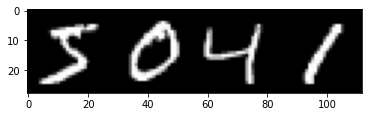

In [6]:
orig = np.zeros((28, 112))
orig[:, :28] = x_train[0]
orig[:, 28:56] = x_train[1]
orig[:, 56:84] = x_train[2]
orig[:, 84:] = x_train[3]
(H, W) = orig.shape[:2]
plt.imshow(orig, cmap='gray');

In [7]:
rects = selective_search(np.dstack([orig, orig, orig]).astype(np.float32))

rois = []
locs = []

for (x, y, w, h) in rects:
    if w / float(W) < 0.1 or h / float(H) < 0.1:
        continue
    roi = orig[y:y + h, x:x + w]
    roi = cv2.resize(roi, INPUT_SIZE)
    
    rois.append(roi)
    locs.append((x, y, w, h))

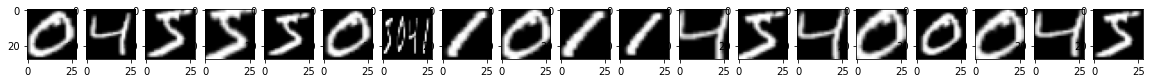

In [8]:
fig, axes = plt.subplots(1, len(rois), figsize=(20, 6))
for ax, roi in zip(axes, rois):
    ax.imshow(roi, cmap='gray')

In [9]:
rois = np.array(rois, dtype="float32")
preds = model.predict(rois)
preds = list(zip(preds.argmax(axis=1).tolist(), preds.max(axis=1).tolist()))
labels = {}

for (i, p) in enumerate(preds):
    (label, prob) = p
    if prob >= MIN_CONF:
        box = locs[i]
        L = labels.get(label, [])
        L.append((box, prob))
        labels[label] = L
preds

2022-03-11 07:32:33.382785: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


[(0, 0.9999998807907104),
 (4, 0.9999994039535522),
 (8, 0.9983437061309814),
 (8, 0.2730371356010437),
 (5, 0.9748801589012146),
 (0, 1.0),
 (4, 0.753673255443573),
 (1, 0.9961546063423157),
 (0, 0.993587851524353),
 (1, 0.980583131313324),
 (1, 0.9999990463256836),
 (4, 0.9488083124160767),
 (8, 0.5567712783813477),
 (7, 0.8934123516082764),
 (0, 0.823907196521759),
 (0, 1.0),
 (0, 0.9938067197799683),
 (4, 0.9999865293502808),
 (8, 0.8583987951278687)]

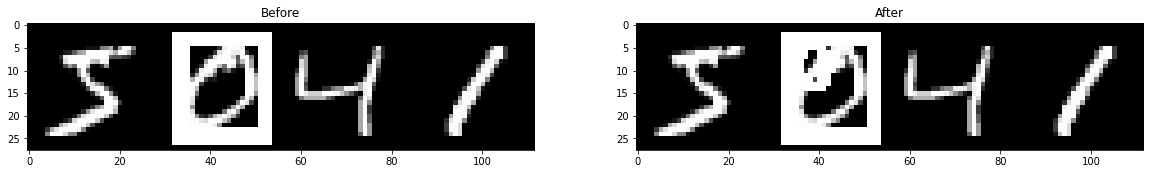

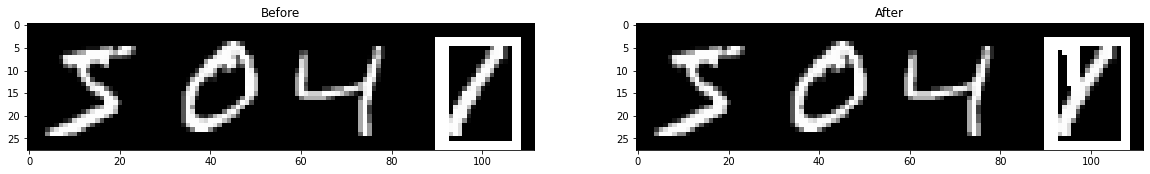

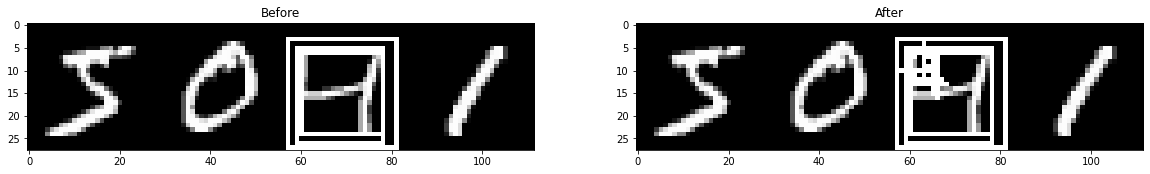

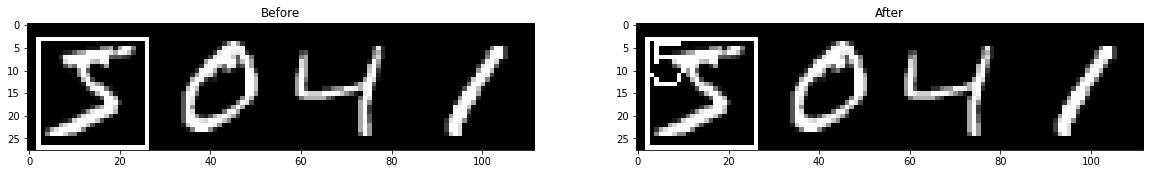

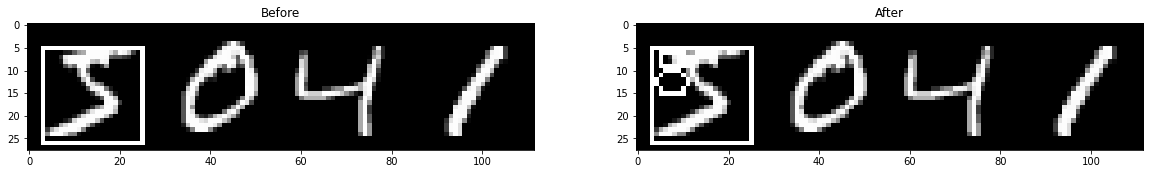

In [10]:
for label in sorted(labels.keys()):
    clone = orig.copy()
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    for (box, prob) in labels[label]:
        (startX, startY, width, height) = box
        endX = startX + width
        endY = startY + height
        cv2.rectangle(clone, (startX, startY), (endX, endY), (255, 255, 255), 1)
    ax[0].imshow(clone, cmap='gray')
    ax[0].set_title("Before")
    clone = orig.copy()
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, proba)

    for (startX, startY, width, height) in boxes:
        cv2.rectangle(clone, (startX, startY), (startX+width, startY+height), (255, 255, 255), 1)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(clone, str(label), (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 255), 1)

    ax[1].imshow(clone, cmap='gray')
    ax[1].set_title("After")

# Ending Notes
* The above approach simplifies what happens in an RCNN
* We can build a Fast RCNN using the same approach, with few additional steps:
  * Data Preparation:
      * Use selective search to detect objects in your image dataset
      * Label those images with appropriate classes and Bounding boxes
  * Modelling:
      * Use a pretrained CNN to extract feature maps from the input image
      * Use selective search to identify ROIs in the input image
      * Use ROI Pooling to project the ROIs into the feature maps
      * Train a downstream classifier to classify the images, and a bounding box regression model